In [2]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from PIL import Image, ImageDraw

#"D:\FinalYearProject\QuickdrawDataCSV\train_simplified"

INPUT_ROOT = r"D:\FinalYearProject\QuickdrawDataCSV"
INPUT_DIR = 'train_simplified'
print(os.listdir(INPUT_ROOT))

['sample_submission.csv', 'test_raw.csv', 'test_simplified.csv', 'train_raw', 'train_simplified']


In [3]:
csv_filenames = glob(os.path.join(INPUT_ROOT, INPUT_DIR, '*.csv'))
column_names = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

row_counts = []
words = []
min_row_count = 999999999

import sys
totalmem_mb = 0
for csv_filename in tqdm(csv_filenames):
    row_count = sum(1 for row in pd.read_csv(csv_filename))
    words.append(pd.read_csv(csv_filename, nrows=1)['word'].values[0])
    row_counts.append(row_count)
    min_row_count = min(min_row_count, row_count)
    
    
    
df =  pd.read_csv(csv_filenames[0], nrows=1)
df.iloc[:,5].values[0]

100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [04:15<00:00,  1.33it/s]


'airplane'

In [4]:
IMHEIGHT, IMWIDTH = 64, 64
NUM_CLASSES = len(row_counts)

def random_row_gen_maker(csv_path, max_index, reservoir_min=3):
    reservoir = [] # list of strokes
    def gen():
        while True:
            if len(reservoir) == 0:
                while len(reservoir) < reservoir_min:
                    r = np.random.randint(1, max_index+1) # [0, max_index) -> [1, max_index]
                    if r==1: df = pd.read_csv(csv_path, nrows=1)
                    else: df = pd.read_csv(csv_path, skiprows=r, nrows=5)

                    if not bool(df.iloc[:, 3].values[0]): continue # 3 -> recognized
                    reservoir.append(ast.literal_eval(df.iloc[:, 1].values[0])) # 1 -> drawing
            strokes = reservoir.pop()

            image = Image.new("P", (256,256), color=255)
            image_draw = ImageDraw.Draw(image)
            for stroke in strokes:
                for i in range(len(stroke[0])-1):
                    image_draw.line( [stroke[0][i], stroke[1][i],
                                      stroke[0][i+1], stroke[1][i+1]],
                                    fill=0, width=5 )
            image = image.resize((IMHEIGHT, IMWIDTH))
            yield (np.array(image)/255.0).copy()
    return gen()


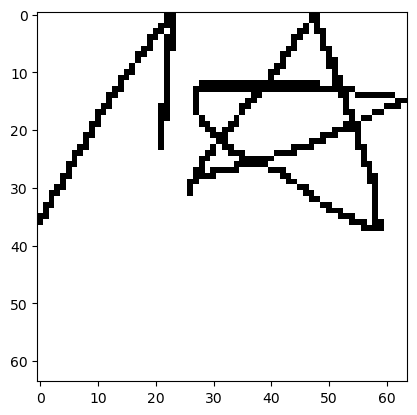

In [5]:
G = random_row_gen_maker(csv_filenames[words.index('star')], 100)

img = next(G)
plt.imshow(img, cmap='gray')

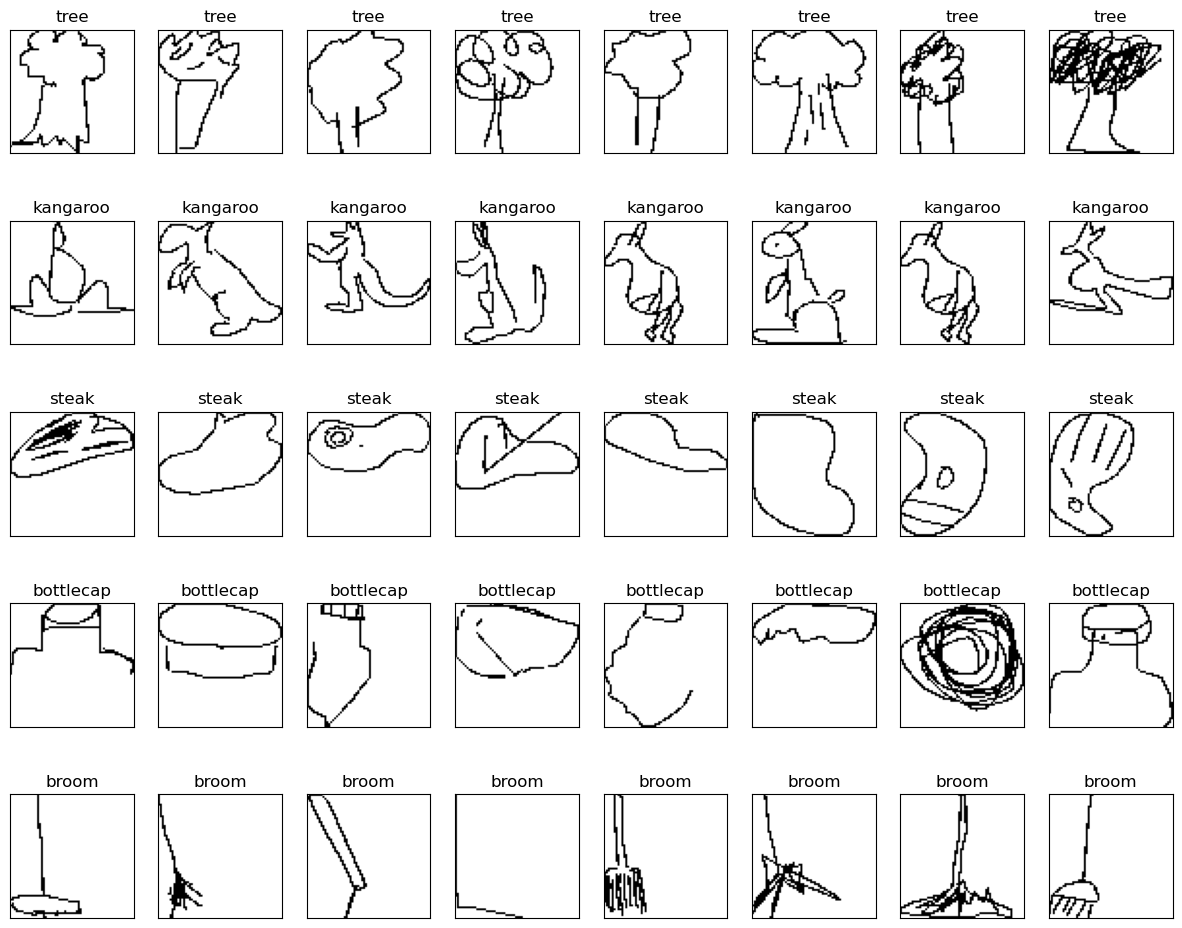

In [6]:
fig = plt.figure(figsize=(15,12))
rows, cols = 5, 8

for i in range(rows):
    row_idx = np.random.randint(0, len(words))
    G = random_row_gen_maker(csv_filenames[row_idx], 100)
    for j in range(cols):
        # plot and titles
        plt.subplot(rows, cols, i*cols+j+1)
        plt.title(words[row_idx])

        # turn off axis ticks
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)

        # gray scale
        plt.imshow(next(G), cmap='gray')

In [7]:
import tensorflow as tf
#print(tf.__version__)
from tensorflow import keras
from keras.utils import to_categorical
#print("installed keras from tensorflow")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def gen(batchsize, max_index=1000):
    while True:
        images = []
        labels = []
        while len(images) < batchsize:
            csv_path = np.random.choice(csv_filenames)
            r = np.random.randint(1, max_index+1) # [0, max_index) -> [1, max_index]
            if r==1: df = pd.read_csv(csv_path, nrows=1)
            else: df = pd.read_csv(csv_path, skiprows=r, nrows=5)

            if not bool(df.iloc[:, 3].values[0]): continue # 3 -> recognized

            ## Get lable
            word = df.iloc[:,5].values[0]

            ## Render the strokes onto an image
            strokes = ast.literal_eval(df.iloc[:, 1].values[0]) # 1 -> drawing

            image = Image.new("P", (256,256), color=255)
            image_draw = ImageDraw.Draw(image)
            for stroke in strokes:
                for i in range(len(stroke[0])-1):
                    image_draw.line( [stroke[0][i], stroke[1][i],
                                      stroke[0][i+1], stroke[1][i+1]],
                                    fill=0, width=5 )
            image = image.resize((IMHEIGHT, IMWIDTH))
            image = np.array(image)/255.0
            # TODO reshape image to input shape

            images.append(image)
            labels.append(words.index(word))
        images = np.array(images)

        ## Transform for fitting/testing
        x = images.reshape(images.shape[0], IMHEIGHT, IMWIDTH, 1)
        y = keras.utils.to_categorical(labels, NUM_CLASSES)
        yield (x, y)

In [8]:
BATCH_SIZE = 1024
train_gen = gen(BATCH_SIZE)
test_gen = gen(BATCH_SIZE)
print(train_gen)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMHEIGHT, IMWIDTH, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

<generator object gen at 0x000002CA9EBA92F0>


C:\Users\thoma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 680)                 │      11,141,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 680)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 340)                 │         231,540 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,392,156 (43.46 MB)

 Trainable params: 11,392,156 (43.46 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import keras

history = model.fit(train_gen, epochs=150, verbose=1,
                    steps_per_epoch=16,
                    validation_data=test_gen,
                    validation_steps=16)


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 170s 11s/step - accuracy: 0.0034 - loss: 5.9064 - val_accuracy: 0.0039 - val_loss: 5.8152
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 166s 11s/step - accuracy: 0.0068 - loss: 5.7953 - val_accuracy: 0.0135 - val_loss: 5.5826
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 169s 11s/step - accuracy: 0.0197 - loss: 5.5329 - val_accuracy: 0.0648 - val_loss: 5.0834
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 148s 10s/step - accuracy: 0.0489 - loss: 5.1366 - val_accuracy: 0.0989 - val_loss: 4.7272
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 148s 10s/step - accuracy: 0.0665 - loss: 4.8918 - val_accuracy: 0.1366 - val_loss: 4.4398
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 147s 10s/step - accuracy: 0.0972 - loss: 4.6308 - val_accuracy: 0.1724 - val_loss: 4.2072
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 147s 10s/step - accuracy: 0.1234 - loss: 4.4181 - val_accuracy: 0.1982 - val_loss: 3.9654
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 148s 10s/step - accuracy: 0.1436 - loss: 4.2432 - val_accu

Epoch 51/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 176s 12s/step - accuracy: 0.4592 - loss: 2.2685 - val_accuracy: 0.5632 - val_loss: 1.8026
Epoch 52/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - accuracy: 0.4613 - loss: 2.2443 - val_accuracy: 0.5703 - val_loss: 1.7872
Epoch 53/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 170s 11s/step - accuracy: 0.4678 - loss: 2.2224 - val_accuracy: 0.5793 - val_loss: 1.7640
Epoch 54/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - accuracy: 0.4563 - loss: 2.2452 - val_accuracy: 0.5701 - val_loss: 1.7571
Epoch 55/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 170s 11s/step - accuracy: 0.4735 - loss: 2.2088 - val_accuracy: 0.5815 - val_loss: 1.7504
Epoch 56/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 173s 11s/step - accuracy: 0.4712 - loss: 2.1933 - val_accuracy: 0.5802 - val_loss: 1.7208
Epoch 57/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - accuracy: 0.4667 - loss: 2.1957 - val_accuracy: 0.5791 - val_loss: 1.7219
Epoch 58/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 170s 11s/step - accuracy: 0.4587 - loss: 2.2235 - 

Epoch 101/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.5261 - loss: 1.8996 - val_accuracy: 0.6667 - val_loss: 1.3312
Epoch 102/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.5407 - loss: 1.8585 - val_accuracy: 0.6776 - val_loss: 1.3186
Epoch 103/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.5385 - loss: 1.8280 - val_accuracy: 0.6637 - val_loss: 1.3467
Epoch 104/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.5362 - loss: 1.8113 - val_accuracy: 0.6699 - val_loss: 1.3290
Epoch 105/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.5415 - loss: 1.8016 - val_accuracy: 0.6713 - val_loss: 1.3081
Epoch 106/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.5551 - loss: 1.7757 - val_accuracy: 0.6754 - val_loss: 1.2960
Epoch 107/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.5344 - loss: 1.8251 - val_accuracy: 0.6752 - val_loss: 1.2698
Epoch 108/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 149s 10s/step - accuracy: 0.5451 - loss: 1

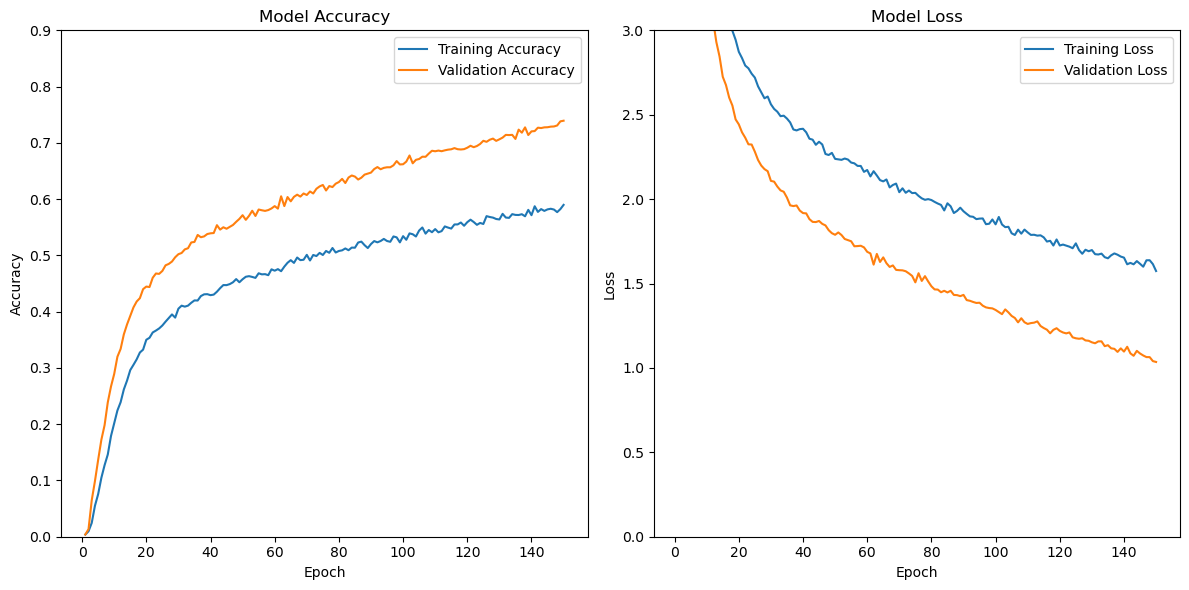

In [10]:
#model.save('g-cnn-generator-25-03-24-150Epoc-1024batSize.h5')
#print("model saved")

epochs = len(history.history['accuracy']) # assuming the history object exists

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 0.9)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 3)

plt.tight_layout()
plt.show()
